In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import pandas as pd

# Check the availability of GPU

In [ ]:
torch.cuda.is_available()

False

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Read the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Recurrent Neural Network (RNN)

/content/drive/MyDrive/CourseMaterial/Supervised Machine Learning/Recurrent Neural Network (RNN)


In [ ]:
data = pd.read_csv('Heterogeneous_accelerometer_HAR.csv')
data.shape

(3540962, 10)

In [ ]:
data.head()

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand


In [ ]:
data.isnull().any()

Index            False
Arrival_Time     False
Creation_Time    False
x                False
y                False
z                False
User             False
Model            False
Device           False
gt                True
dtype: bool

In [ ]:
data.dropna(inplace = True)

In [ ]:
data.isnull().any()

Index            False
Arrival_Time     False
Creation_Time    False
x                False
y                False
z                False
User             False
Model            False
Device           False
gt               False
dtype: bool

# Select the relevant columns

In [ ]:
har = data[['x','y','z','gt']]

In [ ]:
har.head()

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand


In [ ]:
har['gt'].unique()

array(['stand', 'sit', 'walk', 'stairsup', 'stairsdown', 'bike'],
      dtype=object)

In [ ]:
stand = har[har['gt'] == 'stand']

In [ ]:
stand

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand
...,...,...,...,...
3486477,5.540131,-8.072464,1.433960,stand
3486478,5.247345,-8.498550,2.364685,stand
3486479,4.909332,-8.253372,2.188538,stand
3486480,4.861725,-8.455704,1.817200,stand


In [ ]:
stand = stand.iloc[0:500,:]

In [ ]:
stand.shape

(500, 4)

In [ ]:
sit = har[har['gt'] == 'sit'].iloc[0:500,:]

In [ ]:
sit.shape

In [ ]:
walk = har[har['gt'] == 'walk'].iloc[0:500,:]

In [ ]:
stairsup = har[har['gt'] == 'stairsup'].iloc[0:500,:]

In [ ]:
stairsdown = har[har['gt'] == 'stairsdown'].iloc[0:500,:]

In [ ]:
bike = har[har['gt'] == 'bike'].iloc[0:500,:]

In [ ]:
harnew = pd.concat([stand, sit, walk, stairsup, stairsdown, bike])

In [ ]:
harnew.shape

(3000, 4)

In [ ]:
harnew

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand
...,...,...,...,...
27728,-8.280347,-0.789488,5.668871,bike
27729,-8.469488,-0.770933,5.674857,bike
27730,-8.678981,-0.626084,5.809530,bike
27731,-8.397662,-0.755969,5.509656,bike


# Convert target to integers

In [ ]:
harnew['gt'].replace(to_replace = 'stand', value = 0, inplace = True)
harnew['gt'].replace(to_replace = 'sit', value = 1, inplace = True)
harnew['gt'].replace(to_replace = 'walk', value = 2, inplace = True)
harnew['gt'].replace(to_replace = 'stairsup', value = 3, inplace = True)
harnew['gt'].replace(to_replace = 'stairsdown', value = 4, inplace = True)
harnew['gt'].replace(to_replace = 'bike', value = 5, inplace = True)

In [ ]:
harnew

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,0
1,-0.832584,-9.713276,-0.606930,0
2,-1.018134,-9.935339,-0.544082,0
3,-1.222838,-10.142437,-0.566229,0
4,-1.577180,-10.480618,-0.402824,0
...,...,...,...,...
27728,-8.280347,-0.789488,5.668871,5
27729,-8.469488,-0.770933,5.674857,5
27730,-8.678981,-0.626084,5.809530,5
27731,-8.397662,-0.755969,5.509656,5


# Function for data preparation



In [ ]:
def data_preparing(df,  winSize):
    X, y = list(), list()
    for i in range(len(df) - winSize):
        features = df.iloc[:,:-1].values
        target = df.iloc[:,-1].values
        X_i = features[i:i+winSize]
        Y_i = target[i+winSize-1]
        X.append(X_i)
        y.append(Y_i)
    return array(X), array(y)

# Apply the data preparation function

In [ ]:
n_features = 3 # this is number of channels
winSize = 100 # this is number of timesteps

X, y = data_preparing(harnew, winSize)
print(X.shape, y.shape)

(2900, 100, 3) (2900,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Transform to Tensor and Using DataLoader

In [ ]:
# Convert to tensor
train_data = torch.tensor(X_train).float()
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test).float()
test_labels = torch.tensor(y_test).long()


# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Place into dataloader
batchsize    = 32
train_loader = DataLoader(train_data, batch_size = batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

# Observe the batches of training and test data

In [ ]:
for X,y in train_loader:
    break
print(X.shape)
print(y.shape)

torch.Size([32, 100, 3])
torch.Size([32])


In [ ]:
print(y)

In [ ]:
for X,y in test_loader:
    break
print(X.shape)
print(y.shape)

torch.Size([580, 100, 3])
torch.Size([580])


In [ ]:
X,y = next(iter(test_loader))
print(X.shape)
print(y.shape)

# Creating the LSTM Model

In [ ]:
class LSTM_model(nn.Module):
  def __init__(self,input_size, num_hidden, num_layers):
    super().__init__()

    # Define  parameters

    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    # LSTM Layer

    self.lstm = nn.LSTM(input_size, num_hidden, num_layers, batch_first = True)

    # Output Layer

    self.out = nn.Linear(num_hidden,6)

  def forward(self,x):

    y, (h,c) = self.lstm(x)
    out = self.out(y)    # Output shape (batch, features, hidden)
    out = out[:,-1,:]    # Reshaped to (batch, hidden)

    return out, (h,c)

# Setting Parameters and create the instance of the model

In [ ]:
input_size  =  n_features
hidden_size = 200
num_layers  =  1
seqlength   = winSize      # T

In [ ]:
 lstmModel = LSTM_model(input_size, hidden_size, num_layers)

# Training and Testing the model

In [ ]:
epochs = 101

# Loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(lstmModel.parameters(), momentum = 0.9, lr = 0.01)

lstmModel.to(device) # placing a model to device

  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 lstmModel.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred, h = lstmModel(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 lstmModel.eval()

 with torch.no_grad():

    for X,y in test_loader:

            X = X.to(device)
            y = y.to(device)


            ypred, h =  lstmModel(X)
            ypred = ypred.cpu()
            y = y.cpu()

 # Appending test accuracy

 testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
 if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')


 epochs : 0  loss :  0.30
 epochs : 10  loss :  0.42
 epochs : 20  loss :  0.25
 epochs : 30  loss :  0.02
 epochs : 40  loss :  0.02
 epochs : 50  loss :  0.01
 epochs : 60  loss :  0.01
 epochs : 70  loss :  0.01
 epochs : 80  loss :  0.01
 epochs : 90  loss :  0.00
 epochs : 100  loss :  0.01


# Plotting and Visualizing the Results

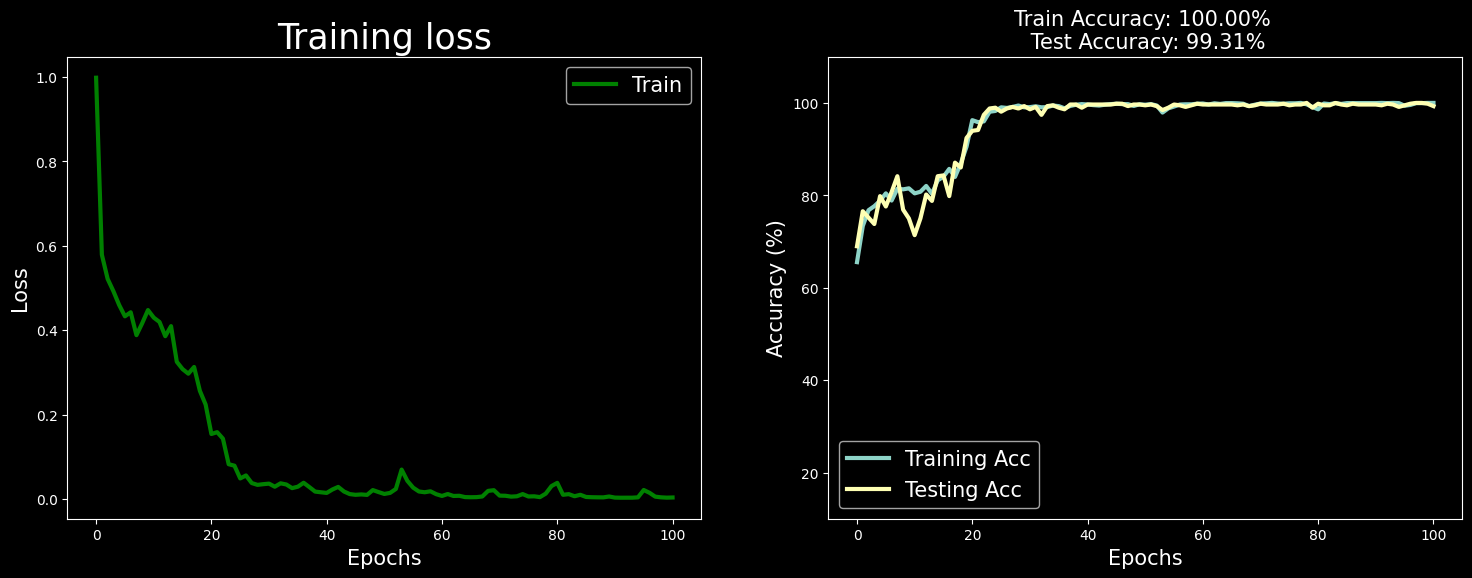

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()